In [1]:
import pandas as pd
import datetime as datetime

In [2]:
securityData = pd.read_csv('iseeData.csv')
index = pd.read_csv('historicalSANDP.csv')

In [3]:
securityData['DATE'] = pd.to_datetime(securityData['DATE'])
index['Date'] = pd.to_datetime(index['Date'])

In [4]:
securityData.head()

,DATE,ALL SECURITIES,10 AVG,20 AVG,50 AVG,ALL EQUITIES,10 AVG.1,20 AVG.1,50 AVG.1,ALL ETFS,10 AVG.2,20 AVG.2,50 AVG.2
0,2006-01-03,149,0,0,0,212,0,0,0,49,0,0,0
1,2006-01-04,180,0,0,0,218,0,0,0,74,0,0,0
2,2006-01-05,195,0,0,0,264,0,0,0,38,0,0,0
3,2006-01-06,144,0,0,0,226,0,0,0,28,0,0,0
4,2006-01-09,188,0,0,0,256,0,0,0,45,0,0,0


In [5]:
index.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2006-01-03,1248.290039,1270.219971,1245.739990,1268.800049,1268.800049,2554570000
1,2006-01-04,1268.800049,1275.369995,1267.739990,1273.459961,1273.459961,2515330000
2,2006-01-05,1273.459961,1276.910034,1270.300049,1273.479980,1273.479980,2433340000
3,2006-01-06,1273.479980,1286.089966,1273.479980,1285.449951,1285.449951,2446560000
4,2006-01-09,1285.449951,1290.780029,1284.819946,1290.150024,1290.150024,2301490000


In [6]:
#adding target variable to s&p data 0 if price goes down 1 if price goes up 
increment = [0] + index['Close'].values.tolist()
index['priceShift'] = increment[:-1] - index['Close'] 
index['target'] = index['priceShift'].apply(lambda x: 0 if x < 0 else 1)

In [7]:
#merging dataframes
index['ISEE All Securities'] = securityData['ALL SECURITIES']
index['ALL EQUITIES'] = securityData['ALL EQUITIES']

In [8]:
from sklearn.linear_model import LogisticRegression

In [9]:
#looking at frequency of two 
frequencies = index['target'].value_counts()

In [10]:
#baseline classifier accuracy
frequencies[0]/frequencies.sum()

0.5433705080545229

In [11]:
model = LogisticRegression()

In [12]:
train = index.iloc[:2000].reset_index(drop=True)

In [13]:
test = index.iloc[2000:].reset_index(drop=True)

In [14]:
### significantly more price down shifts than up shifts
test['target'].value_counts()

0    656
1    572
Name: target, dtype: int64

In [15]:
features = ['ISEE All Securities', 'ALL EQUITIES']

In [16]:
model.fit(train[features], train['target'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [17]:

predictions = model.predict(test[features])

In [18]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [19]:
confusion_matrix(test['target'], predictions)
accuracy_score(test['target'], predictions)

0.5684039087947883

Confusion matrix, without normalization
[[251 405]
 [125 447]]


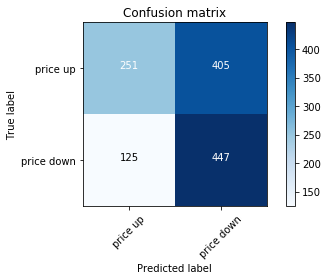

In [20]:
plot_confusion_matrix(confusion_matrix(test['target'], predictions), classes=['price up', 'price down'])

In [21]:
from sklearn.metrics import roc_auc_score



In [22]:
roc_auc_score(test['target'], predictions)

0.5820452413440218

In [23]:
matthews_corrcoef(test['target'], predictions)

0.17759044961832265

### predicting from reddit data

In [32]:
with open('data.json') as x:
    unstructured = json.loads(x.read())

In [33]:
len(unstructured)

2078

In [34]:
dates = list(unstructured.keys())
datetime = pd.to_datetime(list(unstructured.keys()))

In [35]:
newDict = {}
for x,y in zip(dates, datetime):
    newDict[y] = ' '.join([comment['body'] for comment in unstructured[x]])

In [36]:
index['words'] = index['Date'].apply(lambda x: newDict[x] if x in newDict.keys() else 'null')

In [37]:
withWords = index[index['words'] != 'null'].reset_index(drop=True)

In [38]:
withWords

,Date,Open,High,Low,Close,Adj Close,Volume,priceShift,target,ISEE All Securities,ALL EQUITIES,words
0,2013-02-19,1519.790039,1530.939941,1519.790039,1530.939941,1530.939941,3748910000,-11.149902,0,99,166,A book review for a book that he actually like...
1,2013-02-20,1530.939941,1530.939941,1511.410034,1511.949951,1511.949951,4240570000,18.989990,1,81,108,http://www.onguardinsurance.com/sr22-insurance...
2,2013-02-21,1511.949951,1511.949951,1497.290039,1502.420044,1502.420044,4274600000,9.529907,1,93,125,"the ""great rotation"" will be one of the market..."
3,2013-02-22,1502.420044,1515.640015,1502.420044,1515.599976,1515.599976,3419320000,-13.179932,0,120,128,"[deleted] John Green, a writer from Indianapol..."
4,2013-02-25,1515.599976,1525.839966,1487.849976,1487.849976,1487.849976,4011050000,27.750000,1,85,111,Not sure. Although I would consider myself a p...
5,2013-02-26,1487.849976,1498.989990,1485.010010,1496.939941,1496.939941,3975280000,-9.089965,0,112,146,"Lol, 10 observation regression, such power! [d..."
6,2013-02-27,1496.939941,1520.079956,1494.880005,1515.989990,1515.989990,3551850000,-19.050049,0,100,193,[deleted] I lost in the western michigan compe...
7,2013-02-28,1515.989990,1525.339966,1514.459961,1514.680054,1514.680054,3912320000,1.309936,1,97,102,I think discussion around derivatives misses t...
8,2013-03-01,1514.680054,1519.989990,1501.479980,1518.199951,1518.199951,3695610000,-3.519897,0,83,130,"&gt; Unfortunately, the biggest problem that b..."
9,2013-03-04,1518.199951,1525.270020,1512.290039,1525.199951,1525.199951,3414430000,-7.000000,0,114,176,They may have it hedged.\n\nThink of it this w...


In [39]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn.ensemble import AdaBoostClassifier

/usr/local/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [40]:
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', AdaBoostClassifier(learning_rate = 1, n_estimators = 300, algorithm = 'SAMME'))])



In [41]:
train = withWords.iloc[0:1000].reset_index(drop=True)

test = withWords.iloc[1000:].reset_index(drop=True)

In [42]:
pipeline.fit(train['words'], train['target'])
results = pipeline.predict(test['words'])

In [43]:
gg = (test['target'] == results)


In [44]:
pd.Series(gg).value_counts()

True     224
False    211
Name: target, dtype: int64

In [45]:
test['target'].value_counts()

0    243
1    192
Name: target, dtype: int64

Confusion matrix, without normalization
[[140 103]
 [108  84]]


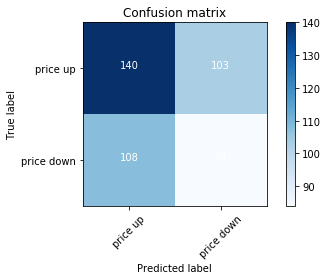

In [46]:
plot_confusion_matrix(confusion_matrix(test['target'], results), classes=['price up', 'price down'])

In [47]:
roc_auc_score(test['target'], results)

0.5068158436213992

In [48]:
matthews_corrcoef(test['target'], results)

0.013672776691671629

In [49]:
accuracy_score(test['target'], results)

0.5149425287356322

going
going
going
going
going
going
going
going
going
going
going
going
going
going
going
going
going
going
going


KeyboardInterrupt: 

In [56]:
redditTitles

{'2018-10-28': [{'author': 'yungyahoo',
   'author_flair_background_color': None,
   'author_flair_css_class': None,
   'author_flair_richtext': [],
   'author_flair_template_id': None,
   'author_flair_text': None,
   'author_flair_text_color': None,
   'author_flair_type': 'text',
   'author_fullname': 't2_zsbrkkf',
   'author_patreon_flair': False,
   'body': 'Any idea what their engineering culture is like?',
   'created_utc': 1540598980,
   'gildings': {'gid_1': 0, 'gid_2': 0, 'gid_3': 0},
   'id': 'e8irrj5',
   'link_id': 't3_9qdmsm',
   'no_follow': True,
   'parent_id': 't1_e8i9fb0',
   'permalink': '/r/finance/comments/9qdmsm/moronic_monday_october_22_2018_your_weekly/e8irrj5/',
   'retrieved_on': 1540598981,
   'score': 1,
   'send_replies': True,
   'stickied': False,
   'subreddit': 'finance',
   'subreddit_id': 't5_2qhfj'},
  {'author': 'YEEEEEEEEEEEE',
   'author_flair_background_color': None,
   'author_flair_css_class': None,
   'author_flair_richtext': [],
   'author_f